# AUDIO

In [1]:
import torch
import torchaudio


print(torch.__version__)
print(torchaudio.__version__)

torch.random.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

2.0.1+cu118
2.0.2+cu118
cuda


In [7]:
waveform, sample_rate = torchaudio.load("Bombus Pratorum [cz7sWbgEueI]-1.wav")



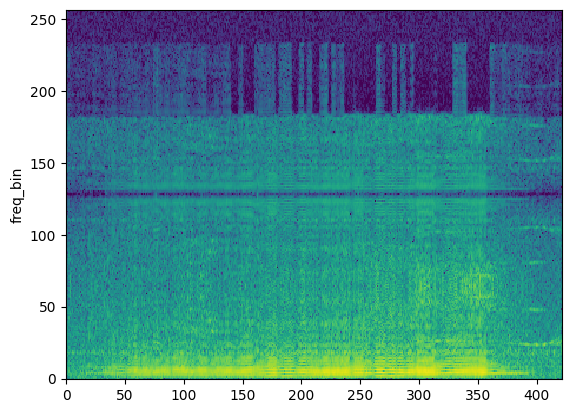

In [4]:
import librosa
import matplotlib.pyplot as plt
from torchaudio.transforms import Spectrogram
spectogram = Spectrogram(n_fft=512)
spec = spectogram(waveform)
def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto", interpolation="nearest")

plot_spectrogram(spec[0])


In [9]:
waveform.to(device=torch.device("cuda"), dtype=torch.float32)

tensor([[ 0.0042,  0.0025, -0.0021,  ...,  0.0152,  0.0161,  0.0141],
        [ 0.0042,  0.0025, -0.0020,  ...,  0.0152,  0.0160,  0.0143]],
       device='cuda:0')

In [11]:
from torchaudio.transforms import *

class MyPipeline(torch.nn.Module):
    def __init__(
        self,
        input_freq=16000,
        resample_freq=8000,
        n_fft=1024,
        n_mel=256,
        stretch_factor=0.8,
    ):
        super().__init__()
        self.resample = Resample(orig_freq=input_freq, new_freq=resample_freq)

        self.spec = Spectrogram(n_fft=n_fft, power=2)

        self.spec_aug = torch.nn.Sequential(
            TimeStretch(stretch_factor, fixed_rate=True),
            FrequencyMasking(freq_mask_param=80),
            TimeMasking(time_mask_param=80),
        )

        self.mel_scale = MelScale(
            n_mels=n_mel, sample_rate=resample_freq, n_stft=n_fft // 2 + 1)

    def forward(self, waveform: torch.Tensor) -> torch.Tensor:
        # Resample the input
        resampled = self.resample(waveform)

        # Convert to power spectrogram
        spec = self.spec(resampled)

        # Apply SpecAugment
        spec = self.spec_aug(spec)

        # Convert to mel-scale
        mel = self.mel_scale(spec)

        return mel
    
# Instantiate a pipeline
pipeline = MyPipeline()

# Move the computation graph to CUDA
pipeline.to(device=torch.device("cuda"), dtype=torch.float32)
waveform = waveform.to(device=torch.device("cuda"), dtype=torch.float32)

# Perform the transform
features = pipeline(waveform)

In [12]:
features

tensor([[[5.8465e-03, 1.8349e-03, 9.5743e-03,  ..., 3.5157e-04,
          3.8995e-03, 2.1254e-03],
         [5.8196e-03, 1.8425e-03, 9.6684e-03,  ..., 6.5895e-04,
          4.8003e-03, 2.3676e-03],
         [2.0221e-03, 1.3953e-03, 9.8650e-03,  ..., 1.4767e-02,
          4.4895e-02, 1.2681e-02],
         ...,
         [1.7555e-04, 2.2226e-04, 1.0023e-04,  ..., 4.9229e-05,
          2.2609e-04, 2.1375e-04],
         [3.6478e-05, 9.2728e-05, 7.1728e-05,  ..., 1.3263e-04,
          6.2951e-05, 3.5717e-04],
         [2.4117e-05, 2.1468e-05, 2.4216e-05,  ..., 1.1731e-05,
          2.7907e-05, 8.8457e-05]],

        [[5.8493e-03, 1.8345e-03, 9.5746e-03,  ..., 3.5187e-04,
          3.8991e-03, 2.1245e-03],
         [5.8224e-03, 1.8421e-03, 9.6687e-03,  ..., 6.5932e-04,
          4.7999e-03, 2.3668e-03],
         [2.0255e-03, 1.3937e-03, 9.8622e-03,  ..., 1.4771e-02,
          4.4893e-02, 1.2686e-02],
         ...,
         [1.7498e-04, 2.2415e-04, 1.0148e-04,  ..., 4.8592e-05,
          2.320

In [14]:
!pip freeze > requirements.txt

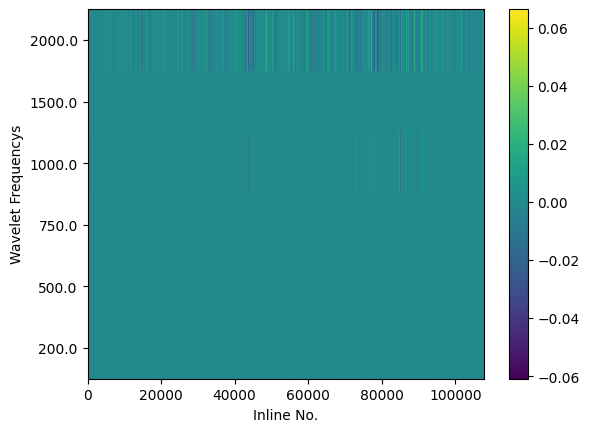

In [59]:
import pywt
import numpy as np

wavelets = pywt.cwt(waveform[0].numpy(), wavelet="morl", scales=pywt.frequency2scale('morl', np.array([2000, 1500, 1000, 750, 500, 200])/1000), sampling_period=0.001)
fig, ax = plt.subplots(1,1)
im = ax.imshow(wavelets[0], interpolation='nearest', aspect='auto', origin='lower')
plt.colorbar(im)
plt.yticks(np.arange(wavelets[0].shape[0])[::-1],np.round(wavelets[1],3))
plt.xlabel('Inline No.')
plt.ylabel('Wavelet Frequencys')
plt.show()


In [47]:
pywt.frequency2scale('morl', np.array([1000, 500, 200, 100, 50, 25, 10, 5, 2])/100)

array([ 0.08125,  0.1625 ,  0.40625,  0.8125 ,  1.625  ,  3.25   ,
        8.125  , 16.25   , 40.625  ])

In [26]:
waveform[0].numpy()

array([ 0.00421143,  0.00253296, -0.0020752 , ...,  0.01516724,
        0.0161438 ,  0.01412964], dtype=float32)

# DATE & LOCATION API

In [2]:
import pandas as pd

inaturalist_bombus_observations = pd.read_csv("observations-386953.csv")

inaturalist_bombus_observations.head()

,id,observed_on_string,observed_on,time_observed_at,time_zone,user_id,user_login,user_name,created_at,updated_at,...,geoprivacy,taxon_geoprivacy,coordinates_obscured,positioning_method,positioning_device,species_guess,scientific_name,common_name,iconic_taxon_name,taxon_id
0,6102,2010-03-17,2010-03-17,NaN,UTC,160,tiggrx,Tig,2010-03-20 06:46:39 +0000,2023-07-17 03:20:37 +0000,...,NaN,NaN,False,NaN,NaN,Large Red-tailed Bumblebee,Bombus lapidarius,Red-tailed Bumble Bee,Insecta,57619
1,6208,2009-03-16,2009-03-16,NaN,UTC,160,tiggrx,Tig,2010-03-24 19:55:17 +0000,2021-04-09 08:21:21 +0000,...,NaN,NaN,False,NaN,NaN,Buff-tailed Bumblebee,Bombus terrestris,Buff-tailed Bumble Bee,Insecta,57516
2,61525,2012-04-01,2012-04-01,NaN,London,4989,acljohn,NaN,2012-04-01 13:59:16 +0000,2021-04-09 08:21:12 +0000,...,NaN,NaN,False,NaN,NaN,Buff-tailed Bumble Bee,Bombus terrestris,Buff-tailed Bumble Bee,Insecta,57516
3,111929,2012-06-04,2012-06-04,NaN,Europe/London,4989,acljohn,NaN,2012-08-12 15:01:28 +0000,2019-09-18 09:52:40 +0000,...,NaN,NaN,False,NaN,NaN,Bumble Bees,Bombus,Bumble Bees,Insecta,52775
4,188227,"August 26, 2012",2012-08-26,NaN,Eastern Time (US & Canada),11758,jaderr,Rebecca Rissanen,2013-01-29 15:40:00 +0000,2020-06-09 11:59:58 +0000,...,NaN,NaN,False,NaN,NaN,Buff-tailed Bumble Bee,Bombus terrestris,Buff-tailed Bumble Bee,Insecta,57516


In [3]:
inaturalist_bombus_observations.columns

Index(['id', 'observed_on_string', 'observed_on', 'time_observed_at',
       'time_zone', 'user_id', 'user_login', 'user_name', 'created_at',
       'updated_at', 'quality_grade', 'license', 'url', 'image_url',
       'sound_url', 'tag_list', 'description', 'num_identification_agreements',
       'num_identification_disagreements', 'captive_cultivated',
       'oauth_application_id', 'place_guess', 'latitude', 'longitude',
       'positional_accuracy', 'private_place_guess', 'private_latitude',
       'private_longitude', 'public_positional_accuracy', 'geoprivacy',
       'taxon_geoprivacy', 'coordinates_obscured', 'positioning_method',
       'positioning_device', 'species_guess', 'scientific_name', 'common_name',
       'iconic_taxon_name', 'taxon_id'],
      dtype='object')

In [44]:
bombus_df = inaturalist_bombus_observations.copy()

bombus_df = bombus_df[['id', 'latitude', 'longitude', 'public_positional_accuracy', 'species_guess', 'scientific_name', 'observed_on']]



In [36]:
print(len(bombus_df['scientific_name'].value_counts()))

25


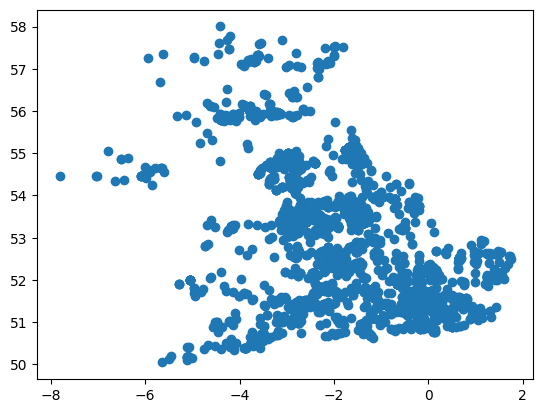

In [37]:
bombus_pratorum = bombus_df[bombus_df['scientific_name'] == 'Bombus pratorum']

import matplotlib.pyplot as plt

plt.scatter(bombus_pratorum['longitude'], bombus_pratorum['latitude'])
plt.show()


# Preprocessing

In [45]:
# Date encoding

def cyclic_encode(df, col, max_val):
    df[col + '_sin'] = np.sin(2 * np.pi * df[col]/max_val)
    df[col + '_cos'] = np.cos(2 * np.pi * df[col]/max_val)
    return df


bombus_df['observed_on'] = pd.to_datetime(bombus_df['observed_on'])
bombus_df['observed_on'] = bombus_df['observed_on'].dt.dayofyear

bombus_df = cyclic_encode(bombus_df, 'observed_on', 365)

In [54]:
# Location encoding

from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
bombus_df['longitude'] = min_max_scaler.fit_transform(bombus_df[['longitude']])
bombus_df['latitude'] = min_max_scaler.fit_transform(bombus_df[['latitude']])

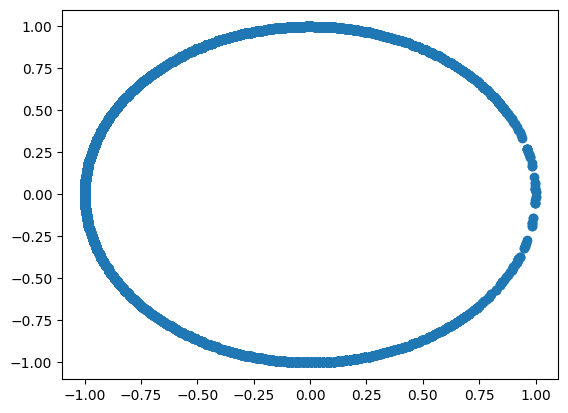

In [46]:
plt.scatter(bombus_df['observed_on_cos'], bombus_df['observed_on_sin'])

In [42]:
bombus_df['observed_on'].min()

1

In [47]:
from sklearn import model_selection

train, test = model_selection.train_test_split(bombus_df, test_size=0.2)

x_train = train[['longitude', 'latitude', 'observed_on_cos', 'observed_on_sin']]
y_train = train[['scientific_name']]
x_test = test[['longitude', 'latitude', 'observed_on_cos', 'observed_on_sin']]
y_test = test[['scientific_name']]

print(y_test.value_counts())

scientific_name                 
Bombus pascuorum                    1390
Bombus terrestris                    867
Bombus hypnorum                      788
Bombus lapidarius                    747
Bombus pratorum                      487
Bombus terrestris audax              132
Bombus hortorum                      117
Bombus vestalis                       82
Bombus monticola                      39
Bombus rupestris                      31
Bombus lucorum                        24
Bombus sylvestris                     17
Bombus muscorum                       17
Bombus jonellus                       15
Bombus bohemicus                      11
Bombus humilis                         8
Bombus sylvarum                        7
Bombus campestris                      7
Bombus ruderatus                       5
Bombus distinguendus                   4
Bombus                                 4
Bombus pascuorum septentrionalis       1
Name: count, dtype: int64


# Method Tests

In [52]:
from sklearn import neighbors
import numpy as np
knn = neighbors.KNeighborsClassifier(n_neighbors=5)

knn.fit(x_train, np.ravel(y_train))

knn.score(x_test, np.ravel(y_test))

0.35333333333333333

In [53]:
from sklearn import linear_model

lr = linear_model.LogisticRegression()
lr.fit(x_train, np.ravel(y_train))

lr.score(x_test, np.ravel(y_test))



d:\Documents\VSCode Projects\bees\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.3020833333333333